# Прогнозирование  временных рядов


### Закачка данных

<font color=darkblue>По данным Сбербанка требуется спрогнозировать данные на ближайшие месяцы.

параметр: months_cnt_to_predict = 6 - число прогнозируемых месяцев</font>

In [6]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:.2f}'.format
#import re
from datetime import date as Date
from numpy import nan as NaN

import matplotlib.pyplot as plt

plt.style.use('classic')
%matplotlib inline


months_cnt_to_predict = 6
df = pd.read_csv(u'../data/sberbank.csv')

In [7]:
df.describe()

,В среднем депозитов в руб. на человека,В среднем руб. на текущем счете на человека,Количество заявок на ипотечные кредиты,Количество заявок на потребительские кредиты,Количество новых депозитов,Средние расходы по картам,Средние траты в ресторане,Средние траты в ресторане фастфуд,Средний чек в формате Ресторан,Средний чек в формате Фастфуд,Средняя зарплата,Средняя пенсия,Средняя сумма заявки на ипотечный кредит,Средняя сумма заявки на потребительский кредит,Средняя сумма нового депозита
count,4452.00,4452.00,5459.00,5460.00,4452.00,4452.00,3444.00,3444.00,3444.00,3444.00,3444.00,4452.00,5459.00,5460.00,4452.00
mean,390008.71,19895.50,2346.24,20427.10,46512.28,8544.97,1548.04,922.69,589.73,340.93,28250.19,14024.36,1512325.01,224534.39,282162.04
std,230240.70,10547.91,11162.33,95041.21,224030.21,4164.34,448.34,223.32,189.02,60.98,12922.41,4002.18,463815.18,69153.20,174739.30
min,163332.00,5081.00,1.00,1.00,148.00,2334.00,715.00,482.00,239.00,199.00,7726.00,1440.00,300000.00,116468.00,77830.00
25%,272306.75,13615.75,352.00,4107.25,6806.00,5573.00,1244.75,760.00,455.00,301.00,20470.50,11817.00,1197482.50,180213.50,197419.75
50%,331575.50,16882.00,744.00,7727.50,16387.50,7615.00,1462.00,881.00,560.00,332.00,24308.50,13284.50,1379216.00,205114.00,244455.50
75%,417426.25,21563.00,1491.00,13909.00,30262.00,10386.00,1744.00,1042.00,691.00,372.00,31560.00,15466.75,1661994.50,243138.25,318988.00
max,2093545.00,87331.00,170936.00,1249665.00,4732173.00,28101.00,3484.00,2190.00,1594.00,624.00,121765.00,43521.00,4600000.00,875000.00,6631650.00


In [8]:
df.columns

Index(['date', 'region', 'В среднем депозитов в руб. на человека',
       'В среднем руб. на текущем счете на человека',
       'Количество заявок на ипотечные кредиты',
       'Количество заявок на потребительские кредиты',
       'Количество новых депозитов', 'Средние расходы по картам',
       'Средние траты в ресторане', 'Средние траты в ресторане фастфуд',
       'Средний чек в формате Ресторан', 'Средний чек в формате Фастфуд',
       'Средняя зарплата', 'Средняя пенсия',
       'Средняя сумма заявки на ипотечный кредит',
       'Средняя сумма заявки на потребительский кредит',
       'Средняя сумма нового депозита'],
      dtype='object')

<font color=darkblue>Выбираем регион и колонку для прогнозирования.
рассмотрим среднюю пенсию</font>

In [9]:
df = df[(df['region'] == 'Москва')]
df['amount'] = df['Средняя пенсия']
df['date'] = pd.to_datetime(df.date)
sberbank = df.set_index("date").amount
sberbank = sberbank.dropna(how='any',axis=0) 
len(sberbank)

53

<font color=darkblue>временной ряд значение выбранной колонки по годам и месяцам.</font>

Text(0, 0.5, 'Сумма')

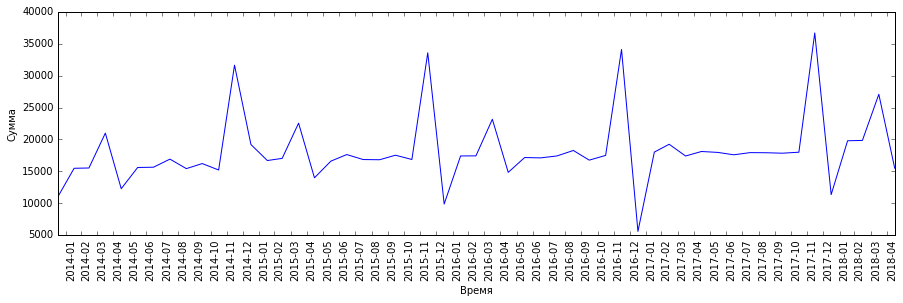

In [10]:
plt.figure(figsize=(15, 4))
xticks = pd.date_range(start=sberbank.index.min(), end=sberbank.index.max(), freq='M')

plt.xticks(xticks, xticks.strftime("%Y-%m"), rotation=90, ha="left")
plt.plot(sberbank, linewidth=1)
plt.xlabel("Время")
plt.ylabel("Сумма")

<font color=darkblue>Подготовка X и y для обработки моделями регрессии
POSIX - количество секунд, прошедших с полуночи (00:00:00 UTC) 1 января 1970 года</font>

In [11]:
y = sberbank.values

# преобразуем время в формат POSIX с помощью "%s" и транспронирование 
X = sberbank.index.astype("int64").values.reshape(-1, 1) // 10**9

<font color=darkblue>Функция для разбивания данных на обучающий и тестовый наборы. и изображения на одном графике исторических данных и прогноза</font>

In [12]:
n_train = len(sberbank) - months_cnt_to_predict


# функция, которая строит модель на данном наборе признаков и визуализирует ее
def eval_on_features(features, target, regressor):
    # разбиваем массив признаков на обучающую и тестовую выборки
    # также разбиваем массив с зависимой переменной
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("качество для тестового набора: {:.2f}".format(regressor.score(X_test, y_test)))

    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize=(15, 4))
    
    plt.xticks(range(0, len(X), 1), xticks.strftime("%Y-%m"), rotation=90, ha="left")
    
    plt.plot(range(n_train), y_train, label="обуч")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="тест")
    plt.plot(range(n_train), y_pred_train, '--', label="прогноз обуч")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="прогноз тест")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Дата")
    plt.ylabel("Количество")

    
n_train

47

## Случайный лес
<font color=darkblue>применим методы, применяемые для решения задачи регрессии. 

Определяем модель "Случайного леса" и вызываем функцию **eval_on_features**.</font>

качество для тестового набора: -0.21


<Figure size 432x288 with 0 Axes>

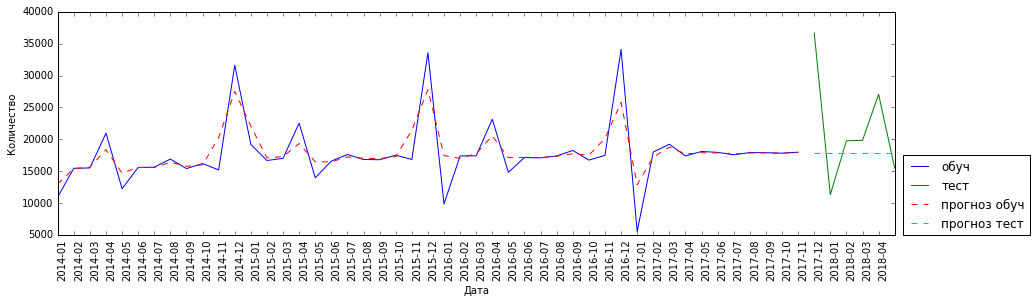

In [13]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
eval_on_features(X, y, regressor)

<font color=darkblue>Правильность прогнозов на обучающем наборе получилась довольно высокой, однако для тестового набора прогнозируется ровная линия.

Проблема обусловлена сочетанием типа нашего признака и используемого метода (в данном случае случайного леса). Значения признака на основе POSIX-времени для тестового набора находятся вне диапазона значений этого признака в обучающей выборке: точки тестового набора в отличие от точек обучающего набора имеют более поздние временные метки. Дерево, а следовательно и случайный лес, не могут *экстраполировать* значения признаков, лежащие вне диапазона значений обучающих данных.

Итог - модель просто предсказывает значение зависимой переменной для ближайшей точки обучающего набора (для последней временной метки, которую она запомнила).

Мы не смогли построить модель, используя время в формате POSIX, поэтому отбрасываем этот признак. Вместо него попробуем признак месяца.</font>

качество для тестового набора: 0.83


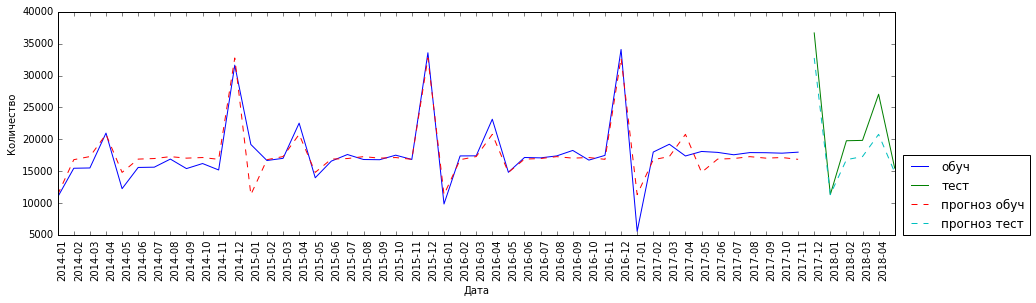

In [14]:
# добавляем признак месяца
X_month = sberbank.index.month.values.reshape(-1, 1)
eval_on_features(X_month, y, regressor)

### Линейная регрессия

качество для тестового набора: 0.04


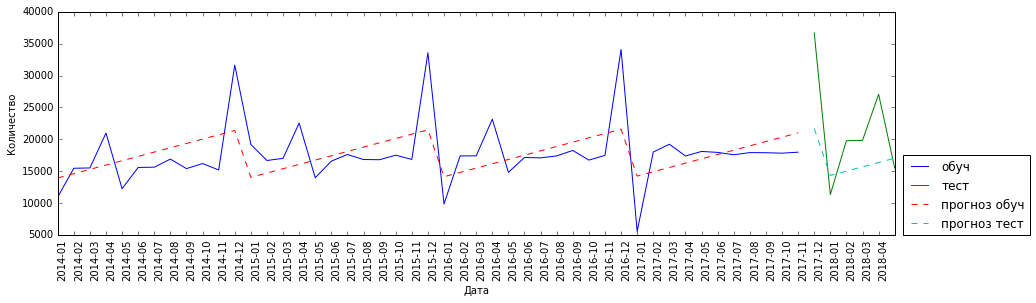

In [15]:
from sklearn.linear_model import LinearRegression
X_year_month = np.hstack([sberbank.index.month.values.reshape(-1, 1), sberbank.index.year.values.reshape(-1, 1)])
eval_on_features(X_year_month, y, LinearRegression())

<font color=darkblue>**LinearRegression** работает гораздо хуже. Причиной этого является тот факт, что *месяц* и *год* закодированы с помощью целочисленных значений и теперь эти характеристики интерпретируются как непрерывные переменные. Однако структура данных сложнее, чем предполагает модель. Это можно учесть, преобразовав признаки, закодированные целыми числами, в дамми-переменные с помощью **OneHotEncoder**.</font>

c:\users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


качество для тестового набора: 0.72


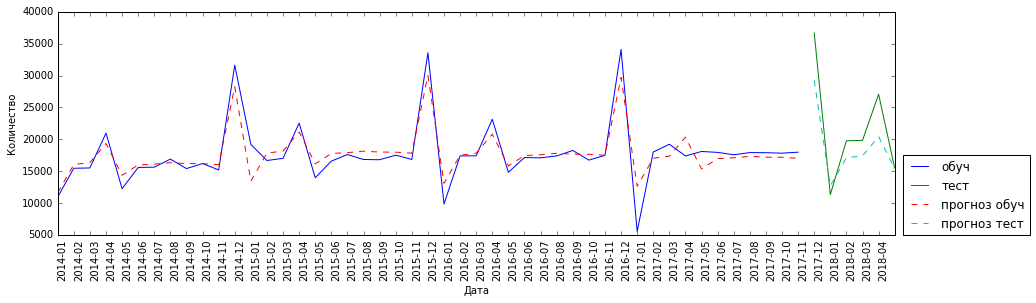

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
enc = OneHotEncoder()
X_year_month_onehot = enc.fit_transform(X_year_month).toarray()
eval_on_features(X_year_month_onehot, y, Ridge())

<font color=darkblue>Добавление полиномиальных признаков не улучшает прогноз</font>

качество для тестового набора: 0.59


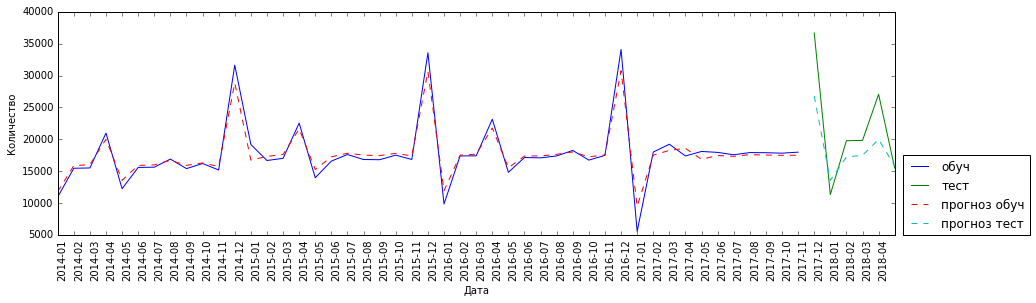

In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_year_month_onehot_poly = poly_transformer.fit_transform(X_year_month_onehot)
lr = Ridge()
eval_on_features(X_year_month_onehot_poly, y, lr)

<font color=darkblue>Применим полученное решение для другого ряда в котором явно выражен тренд</font>

In [18]:
df = df[(df['region'] == 'Москва')]
df['amount'] = df['Средние расходы по картам']
df['date'] = pd.to_datetime(df.date)
y = sberbank.values
sberbank = df.set_index("date").amount
sberbank = sberbank.dropna(how='any',axis=0) 
len(sberbank)

53

Text(0, 0.5, 'Сумма')

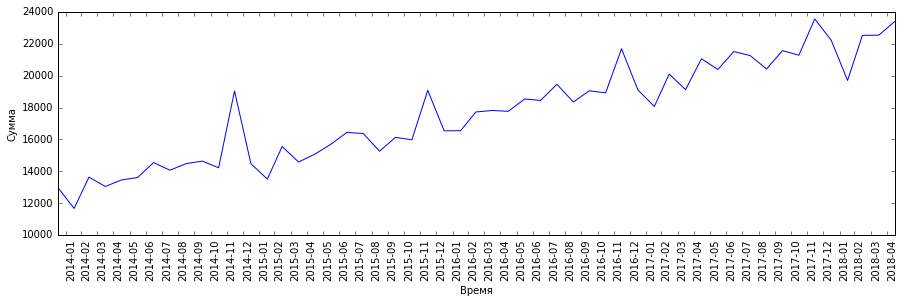

In [19]:
plt.figure(figsize=(15, 4))
xticks = pd.date_range(start=sberbank.index.min(), end=sberbank.index.max(), freq='M')

plt.xticks(xticks, xticks.strftime("%Y-%m"), rotation=90, ha="left")
plt.plot(sberbank, linewidth=1)
plt.xlabel("Время")
plt.ylabel("Сумма")

<font color=darkblue>на основе леса деревьев</font>

качество для тестового набора: -19.36


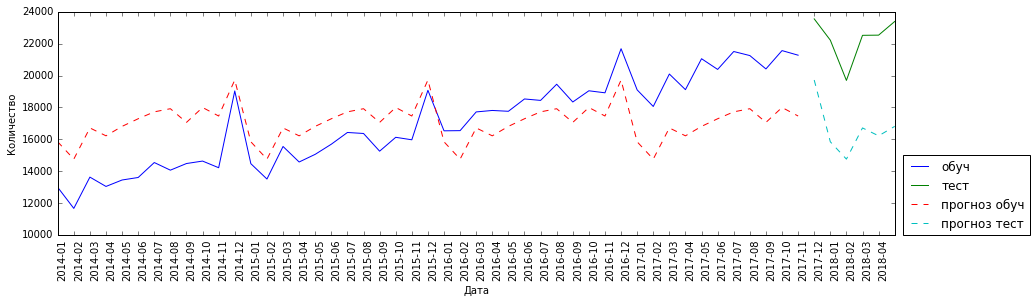

In [22]:
y = sberbank.values
X_month = sberbank.index.month.values.reshape(-1, 1)
eval_on_features(X_month, y, RandomForestRegressor(n_estimators=100, random_state=0))

<font color=darkblue>Линейная модель</font>

качество для тестового набора: 0.09


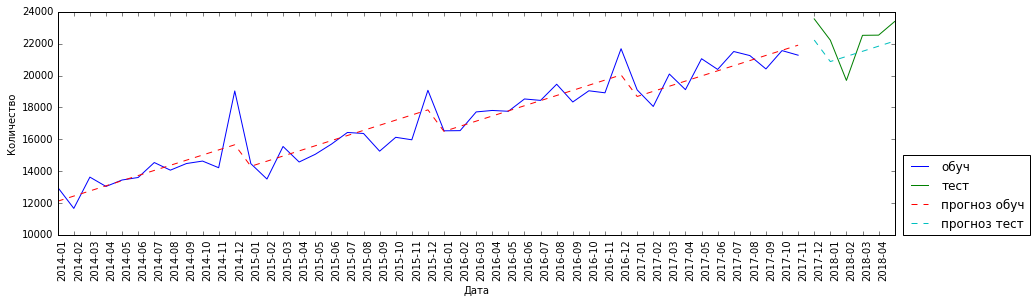

In [23]:
from sklearn.linear_model import LinearRegression
X_year_month = np.hstack([sberbank.index.month.values.reshape(-1, 1), sberbank.index.year.values.reshape(-1, 1)])
eval_on_features(X_year_month, y, LinearRegression())